# MuJoCo basics

We begin by defining and loading a simple model:

In [1]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt

import time
import itertools
import numpy as np

## Friction

Let's see the effect of changing friction values

In [7]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="6 6"
     texuniform="true" reflectance=".2"/>
     <material name="wall" rgba='.5 .5 .5 1'/>
  </asset>

  <default>
    <geom type="box" size=".05 .05 .05" />
    <joint type="free"/>
  </default>

  <worldbody>
    <light name="light" pos="-.2 0 1"/>
    <geom name="ground" type="plane" size=".5 .5 10" material="grid"
     zaxis="-.3 0 1" friction=".1"/> 
    <camera name="y" pos="-.1 -.6 .3" xyaxes="1 0 0 0 1 2"/>
    <body pos="0 0 .1">
      <joint/>
      <geom/>
    </body>
    <body pos="0 .2 .1">
      <joint/>
      <geom friction=".33"/>
    </body>
  </worldbody>

</mujoco>
"""
n_frames = 60
height = 300
width = 300
frames = []

# load
model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, height, width)

# simulate and render
mujoco.mj_resetData(model, data)
for i in range(n_frames):
  while data.time < i/30.0:
    mujoco.mj_step(model, data)
  renderer.update_scene(data, "y")
  frame = renderer.render()
  frames.append(frame)
media.show_video(frames, fps=30)

# Tendons, actuators and sensors

""

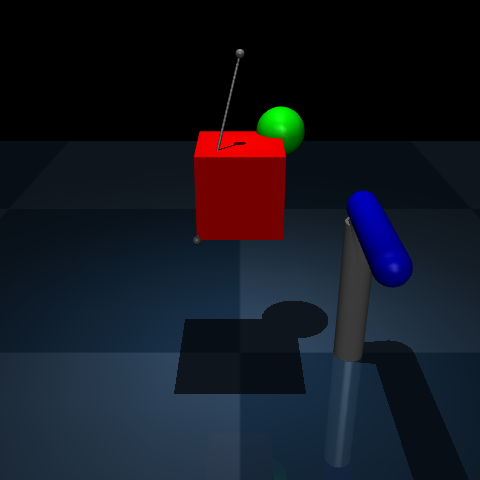

In [10]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="1 1"
     texuniform="true" reflectance=".2"/>
  </asset>

  <worldbody>
    <light name="light" pos="0 0 1"/>
    <geom name="floor" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid"/>
    <site name="anchor" pos="0 0 .3" size=".01"/>
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>

    <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04"/>
    <body name="bat" pos=".3 0 -.1">
      <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>
      <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04"
       size=".04" rgba="0 0 1 1"/>
    </body>

    <body name="box_and_sphere" pos="0 0 0">
      <joint name="free" type="free"/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1"/>
      <geom name="green_sphere"  size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <site name="hook" pos="-.1 -.1 -.1" size=".01"/>
      <site name="IMU"/>
    </body>
  </worldbody>

  <tendon>
    <spatial name="wire" limited="true" range="0 0.35" width="0.003">
      <site site="anchor"/>
      <site site="hook"/>
    </spatial>
  </tendon>

  <actuator>
    <motor name="my_motor" joint="swing" gear="1"/>
  </actuator>

  <sensor>
    <accelerometer name="accelerometer" site="IMU"/>
  </sensor>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(MJCF)
renderer = mujoco.Renderer(model, 480, 480)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data, "fixed")
media.show_image(renderer.render())


actuated bat and passive "piñata":

In [11]:
n_frames = 180
height = 240
width = 320
frames = []
fps = 60.0
times = []
sensordata = []

renderer = mujoco.Renderer(model, height, width)

# constant actuator signal
mujoco.mj_resetData(model, data)
data.ctrl = 20

# simulate and render
for i in range(n_frames):
  while data.time < i/fps:
    mujoco.mj_step(model, data)
    times.append(data.time)
    sensordata.append(data.sensor('accelerometer').data.copy())
  renderer.update_scene(data, "fixed")
  frame = renderer.render()
  frames.append(frame)

media.show_video(frames, fps=fps)

Let's plot the values measured by our accelerometer sensor:

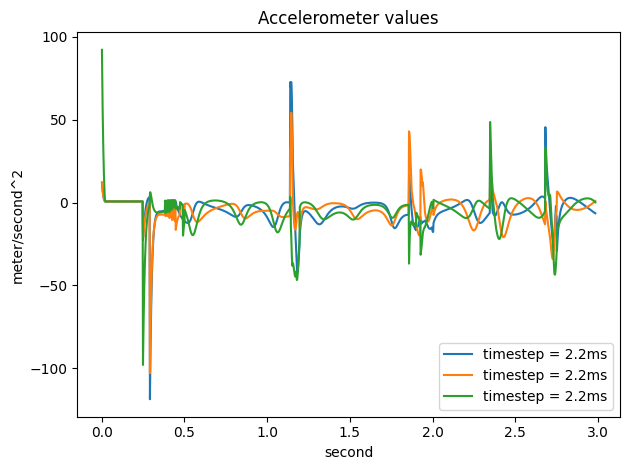

In [12]:
ax = plt.gca()
dt = 0.0022
ax.plot(np.asarray(times), np.asarray(sensordata), label='timestep = {:2.2g}ms'.format(1000*dt))

# finalize plot
ax.set_title('Accelerometer values')
ax.set_ylabel('meter/second^2')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right');
plt.tight_layout()

Note how the moments when the body is hit by the bat are clearly visible in the accelerometer measurements.